# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 3: 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [307]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [310]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [313]:
# 한글 표시를 위한 라이브러리 설치
#!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [316]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [319]:
# 파일 읽어오기
data = joblib.load(path+'base_data2.pkl')

# 확인
data.head()

,총면적,총세대수,준공연도,건물형태,난방방식,승강기설치여부,실차량수,면적10-30,면적30-40,면적40-50,면적50-60,면적60-70,면적70-80,면적80-200,임대보증금,임대료
0,6023.7683,78,2013,계단식,개별,1,109,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,1569.1668,35,2013,복도식,개별,1,35,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,7180.1396,88,2013,계단식,개별,1,88,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,47058.9273,477,2014,복도식,지역,1,943,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,543.0268,15,2013,복도식,개별,1,21,15,0,0,0,0,0,0,5.522750e+07,340148.333333


In [321]:
# 세대당 평균 면적을 추가
data['세대당 평균 면적'] = data['총면적'] / data['총세대수']
# 임대료 대비 보증금 비율을 추가
data['임대료 대비 보증금 비율'] = data['임대료'] / data['임대보증금']

In [323]:
# 확인
data.head()

,총면적,총세대수,준공연도,건물형태,난방방식,승강기설치여부,실차량수,면적10-30,면적30-40,면적40-50,면적50-60,면적60-70,면적70-80,면적80-200,임대보증금,임대료,세대당 평균 면적,임대료 대비 보증금 비율
0,6023.7683,78,2013,계단식,개별,1,109,0,0,0,78,0,0,0,5.696200e+07,642930.000000,77.227799,0.011287
1,1569.1668,35,2013,복도식,개별,1,35,35,0,0,0,0,0,0,6.306200e+07,470100.000000,44.833337,0.007455
2,7180.1396,88,2013,계단식,개별,1,88,0,0,0,88,0,0,0,7.219000e+07,586540.000000,81.592495,0.008125
3,47058.9273,477,2014,복도식,지역,1,943,0,0,0,150,0,216,111,1.015167e+08,950305.000000,98.656032,0.009361
4,543.0268,15,2013,복도식,개별,1,21,15,0,0,0,0,0,0,5.522750e+07,340148.333333,36.201787,0.006159


### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [326]:
# 실젯값, 예측값 비교 함수 만들기
# def model_plot(y_test, y_pred):
#     plt.figure(figsize=(10, 3))
#     plt.plot(y_test.values, label='Actual', linewidth=0.7, marker='o', markersize=2)
#     plt.plot(y_pred, label='Predicted', linewidth=0.7, marker='o', markersize=2)
#     plt.legend()
#     plt.show()

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [331]:
data.isnull().sum()

총면적               0
총세대수              0
준공연도              0
건물형태              0
난방방식              0
승강기설치여부           0
실차량수              0
면적10-30           0
면적30-40           0
면적40-50           0
면적50-60           0
면적60-70           0
면적70-80           0
면적80-200          0
임대보증금             0
임대료               0
세대당 평균 면적         0
임대료 대비 보증금 비율    36
dtype: int64

In [333]:
#특정값으로 채우기
##평균값으로 구하기
median=data['임대료 대비 보증금 비율'].median()
##NaN을 평균값으로 채우기
data['임대료 대비 보증금 비율'].fillna(median,inplace=True)

In [335]:
col_dummies=['건물형태','난방방식']
data=pd.get_dummies(data,columns=col_dummies,drop_first=True,dtype=int)

#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [338]:
#Target 지정
target='실차량수'

x=data.drop(columns=target)
y=data.loc[:,target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [341]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.3,random_state=1)

#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [344]:
#데이터 스케일링
scaler=MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)  # 학습 데이터 스케일링 및 변환
x_test_s = scaler.transform(x_val)  # 테스트 데이터 변환

### (2) 모델 1: KNN

In [347]:
#모델 선언
knn_model=KNeighborsRegressor()
#검증하기
knn_cv_score=cross_val_score(knn_model,x_train_s,y_train,cv=10,scoring='r2')

print('knn cv 평균:',knn_cv_score.mean())#정확도
print('knn cv 표준편차:',knn_cv_score.std())# 표준편차

knn cv 평균: 0.6276878189415712
knn cv 표준편차: 0.09008597986145211


In [348]:
result={}
result['KNN']=knn_cv_score.mean()

In [349]:
# 모델저장
joblib.dump(knn_model, 'knn_model.pkl')

['knn_model.pkl']

### (3) 모델 2: DecisionTreeRegressor

In [351]:
#모델 선언
dt_model=DecisionTreeRegressor()
#검증하기
dt_model_score=cross_val_score(dt_model,x_train,y_train,cv=10,scoring='r2')

print('dt cv 평균:',dt_model_score.mean())#정확도
print('dt cv 표준편차:',dt_model_score.std())# 표준편차

dt cv 평균: 0.38423976742795585
dt cv 표준편차: 0.19933017237103373


In [353]:
result['DecisionTreeRegressor']=dt_model_score.mean()

In [358]:
# 모델저장
joblib.dump(dt_model, 'dt_model.pkl')

['dt_model.pkl']

### (4) 모델 3: RandomForest

In [361]:
random_forest=RandomForestRegressor()
random_forest_score=cross_val_score(random_forest,x_train,y_train,cv=10,scoring='r2')
print('dt cv 평균:',random_forest_score.mean())#정확도
print('dt cv 표준편차:',random_forest_score.std())# 표준편차

dt cv 평균: 0.7097241222090539
dt cv 표준편차: 0.10586433907802234


In [362]:
result['RandomForest']=random_forest_score.mean()

In [363]:
# 모델저장
joblib.dump(random_forest, 'random_forest.pkl')

['random_forest.pkl']

### (5) 모델 4: XGBoost

In [365]:
xgb_model=XGBRegressor()
xgb_model_score=cross_val_score(xgb_model,x_train,y_train,cv=10,scoring='r2')
print('xgb cv 평균:',xgb_model_score.mean())#정확도
print('xgb 표준편차:',xgb_model_score.std())# 표준편차

xgb cv 평균: 0.6671295673234978
xgb 표준편차: 0.11728866705375361


In [366]:
result['XGBRegressor']=xgb_model_score.mean()

In [367]:
# 모델저장
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

### (6) 모델 5: LGBM

In [369]:
lgbm_model=LGBMRegressor()
lgbm_model_score=cross_val_score(lgbm_model,x_train,y_train,cv=10,scoring='r2')
print('lgbm cv 평균:',lgbm_model_score.mean())#정확도
print('lgbm 표준편차:',lgbm_model_score.std())# 표준편차

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 16
[LightGBM] [Info] Start training from score 555.976852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [370]:
result['LGBM']=lgbm_model_score.mean()

### (7) 모델 6: LiearRegression

In [372]:
linear_model=LinearRegression()
linear_model_score=cross_val_score(linear_model,x_train,y_train,cv=10,scoring='r2')
print('linear cv 평균:',linear_model_score.mean())#정확도
print('linear 표준편차:',linear_model_score.std())# 표준편차

linear cv 평균: 0.3900294184121981
linear 표준편차: 0.9585604539521095


In [373]:
result['Linear']=linear_model_score.mean()

In [374]:
# 모델저장
joblib.dump(linear_model, 'linear_model.pkl')

['linear_model.pkl']

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

In [376]:
# 성능 비교
print(result)

{'KNN': 0.6276878189415712, 'DecisionTreeRegressor': 0.38423976742795585, 'RandomForest': 0.7097241222090539, 'XGBRegressor': 0.6671295673234978, 'LGBM': 0.6622485704836596, 'Linear': 0.3900294184121981}


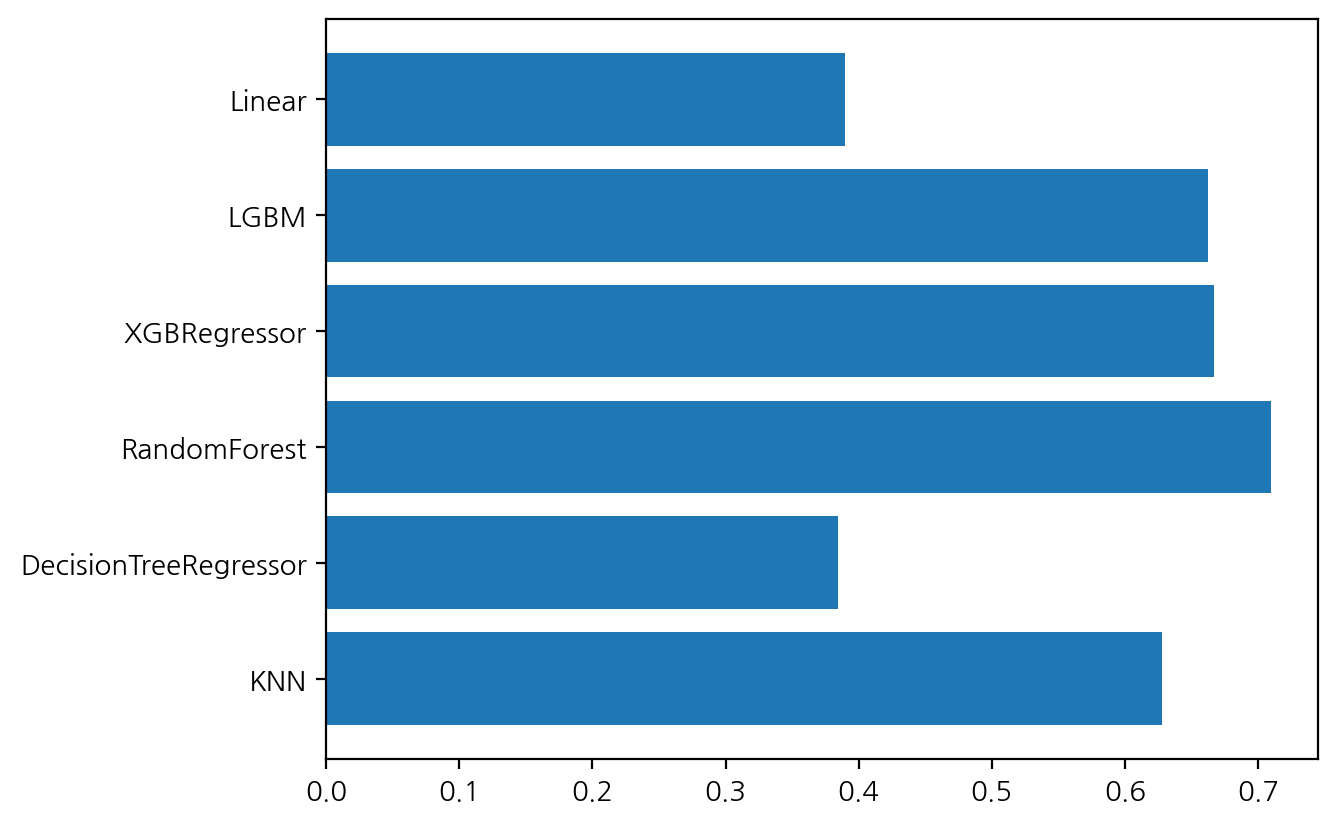

In [377]:
# 성능 시각화 비교
plt.barh(list(result),result.values())
plt.show()

In [378]:
# 파라미터 
param = {'max_depth': range(1, 21),
         'n_estimators': range(60, 131, 10)}

model=GridSearchCV(RandomForestRegressor(),
                  param)
model2=GridSearchCV(RandomForestRegressor(),
                  param)

In [379]:
#최고의 성능 모델 학습
model.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 21),
                         'n_estimators': range(60, 131, 10)})

In [425]:
# 최적 파라미터, 예측 최고 성능
print('최적 파라미터:',model.best_params_)
print('최고 성능:',model.best_score_)

최적 파라미터: {'max_depth': 5, 'n_estimators': 90}
최고 성능: 0.7314088110121909


In [427]:
y_pred=model.predict(x_val)

In [429]:
print('r2_score:',r2_score(y_val,y_pred))
print('mean_absolute_error:',mean_absolute_error(y_val,y_pred))

r2_score: 0.7553338673270795
mean_absolute_error: 136.06942239796257


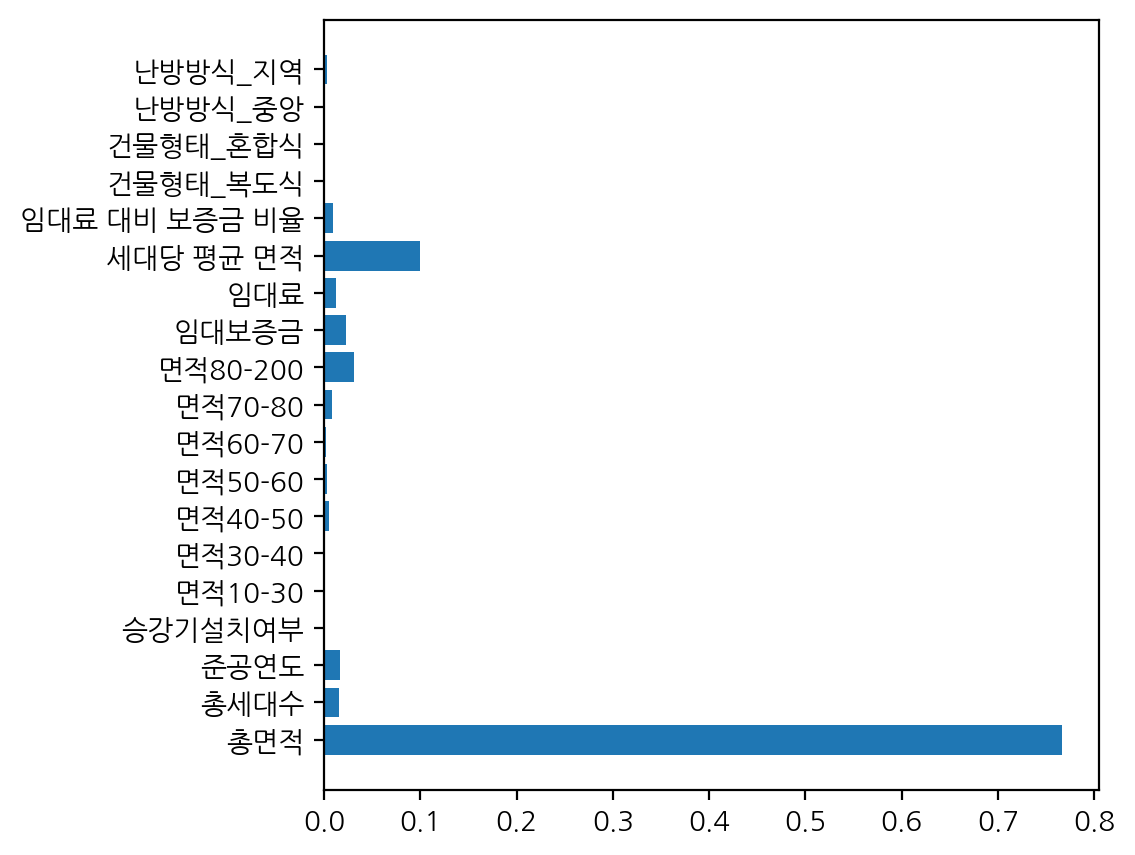

In [431]:
# 변수 중요도 시각화
plt.figure(figsize=(5,5))
plt.barh(list(x),width=model.best_estimator_.feature_importances_)
plt.show()

In [438]:
# 모델저장
joblib.dump(model, 'model.pkl')

['model.pkl']

## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [442]:
# 파일 읽어오기
new_data = pd.read_excel(path+'test.xlsx')

# 확인
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      104 non-null    object 
 1   단지명       104 non-null    object 
 2   총세대수      104 non-null    int64  
 3   전용면적별세대수  104 non-null    int64  
 4   지역        104 non-null    object 
 5   준공일자      104 non-null    int64  
 6   건물형태      100 non-null    object 
 7   난방방식      103 non-null    object 
 8   승강기설치여부   95 non-null     object 
 9   단지내주차면수   104 non-null    int64  
 10  전용면적      104 non-null    float64
 11  공용면적      104 non-null    float64
 12  임대보증금     104 non-null    int64  
 13  임대료       104 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 11.5+ KB


### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 단지모드, 지역 변수 제거
    - 가변수화

In [445]:
def data_pipeline(data):
    # 결측치 처리
    for column in ['건물형태', '난방방식', '승강기설치여부']:
        if data[column].isnull().any():
            data[column].fillna(data[column].mode()[0], inplace=True)

    # 변수 추가
        # 변수 추가
    data['준공연도'] = data['준공일자'].astype(str).str[0:4].astype(int)
    data['총면적'] = (data['전용면적'] + data['공용면적']) * data['전용면적별세대수']

    # 단지데이터, 상세데이터 분리
    data01 = data[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부']]
    data01 = data01.drop_duplicates().reset_index(drop=True)

    # 단지코드별 총면적 합 집계
    data02 = data[['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    df_area = data02.groupby(['단지코드'], as_index=False)['총면적'].sum()
    
    # 전용면적 구간별 집계 (ensure no duplicates by summing 세대수 for duplicate 전용면적구간)
    bins = [10, 30, 40, 50, 60, 70, 80, 200]
    labels = ['면적10-30', '면적30-40', '면적40-50', '면적50-60', '면적60-70', '면적70-80', '면적80-200']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=bins, labels=labels, right=False)
    df_pivot = data02.groupby(['단지코드', '전용면적구간'], as_index=False)['전용면적별세대수'].sum()
    df_pivot = df_pivot.pivot(index='단지코드', columns='전용면적구간', values='전용면적별세대수').reset_index()

    # 임대보증금, 임대료 평균 집계
    df_rent = data02.groupby(['단지코드'], as_index=False)[['임대보증금', '임대료']].mean()

    # 집계 결과 병합
    base_data = pd.merge(df_area, data01, how='left', on='단지코드')
    base_data = pd.merge(base_data, df_pivot, how='left', on='단지코드')
    base_data = pd.merge(base_data, df_rent, how='left', on='단지코드')

    # 난방 방식 통합
    heating_replacements = {
        '개별가스난방': '개별', '개별유류난방': '개별',
        '지역난방': '지역', '지역가스난방': '지역', '지역유류난방': '지역',
        '중앙가스난방': '중앙', '중앙난방': '중앙', '중앙유류난방': '중앙'
    }
    data.replace(heating_replacements, inplace=True)

    # 승강기 설치 여부 변환
    elevator_replacements = {
        '전체동 설치': 1,
        '일부동 설치': 0,
        '미설치': 0
    }
    data.replace(elevator_replacements, inplace=True)

    # 단지코드, 지역 변수 제거
    base_data.drop(columns=['단지코드', '지역'], inplace=True)

    #변수 추가
    ##세대당 평균 면적을 추가
    base_data['세대당 평균 면적'] = base_data['총면적'] / base_data['총세대수']
    ##임대료 대비 보증금 비율을 추가
    base_data['임대료 대비 보증금 비율'] = base_data['임대료'] / base_data['임대보증금']
    ###추가한 데이터결측치 전처리
    #특정값으로 채우기
    ##평균값으로 구하기
    median=base_data['임대료 대비 보증금 비율'].median()
    ##NaN을 평균값으로 채우기
    base_data['임대료 대비 보증금 비율'].fillna(median,inplace=True)
    
    # 가변수화
    col_dummies = ['건물형태', '난방방식']
    base_data = pd.get_dummies(base_data, columns=col_dummies, drop_first=True, dtype=int)

    return base_data  # 처리된 데이터 반환


### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [448]:
# 데이터 전처리
data = data_pipeline(new_data)

# 확인
data.head()

,총면적,총세대수,준공연도,승강기설치여부,면적10-30,면적30-40,면적40-50,면적50-60,면적60-70,면적70-80,면적80-200,임대보증금,임대료,세대당 평균 면적,임대료 대비 보증금 비율,건물형태_복도식,건물형태_혼합식,난방방식_중앙난방,난방방식_지역가스난방,난방방식_지역난방
0,766.2736,20,2012,전체동 설치,20,0,0,0,0,0,0,5.236067e+07,305753.333333,38.313680,0.005839,1,0,0,0,0
1,31396.0944,822,2018,전체동 설치,0,0,0,404,0,0,0,3.546600e+07,445466.666667,38.194762,0.012560,0,0,0,0,1
2,12450.4308,112,2014,전체동 설치,0,0,0,0,0,20,92,9.869750e+07,744450.000000,111.164561,0.007543,0,0,0,0,1
3,13081.4772,122,2011,전체동 설치,0,0,0,0,0,22,100,0.000000e+00,0.000000,107.225223,0.008011,0,0,0,1,0
4,28141.7516,262,2011,전체동 설치,0,0,0,0,0,77,185,0.000000e+00,0.000000,107.411266,0.008011,0,0,0,1,0


In [450]:
model4=RandomForestRegressor(max_depth=8,n_estimators=100)

In [452]:
# 예측하기
predicted = model4.predict(data)

# 확인
print(predicted)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [ ]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result = new_data[vars].copy()
result = result.drop_duplicates()
result.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result['예상차량수'] = predicted.round(1).astype(int)

# 확인
result